In [1]:
# Multiplicative scaling constants
B_b   = 1e1
b_B   = 1/B_b
G_1   = 1e9
one_G = 1/G_1
G_K   = 1e6
K_G   = 1/G_K
G_M   = 1e3
M_G   = 1/G_M
K_1   = 1e3
one_K = 1/K_1
M_1   = 1e6
one_M = 1/M_1
m_1   = 1e-3
one_m = 1/m_1
m_u   = 1e3 
u_m   = 1/m_u
u_1   = 1e-6
one_u = 1/u_1
n_1   = 1e-9
one_n = 1/n_1
n_m   = 1e-6
m_n   = 1/n_m
n_u   = 1e-3
u_n   = 1/n_u

sz1K  = 1024
sz1M  = sz1K*sz1K
sz1G  = sz1M*sz1K


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import re
from datetime import datetime

sns.set(style="darkgrid")

# Compute statistical moments: mean, std, skewness, kurtosis
def compute_moments(series):
    values = series #.dropna()
    return {
        'count': len(values),
        'mean': values.mean(),
        'std': values.std(),
        'skew': skew(values),
        'kurtosis': kurtosis(values)
    }

# Load the log file into a list of lines
def load_log_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines if line.strip()]


In [3]:
pip install pyyaml

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yaml
import pandas as pd
from pandas import json_normalize

# Load YAML
with open("cpu_emu.yaml", "r") as f:
    data = yaml.safe_load(f)

# Flatten into a DataFrame
prmtrs_df = json_normalize(data, sep=".")
print(prmtrs_df.T)  # transpose to make it easier to read

cmp_ltnc_nS_B   = float(prmtrs_df['latency'].iloc[0])
output_size_GB  = float(prmtrs_df['output_size'].iloc[0])
frame_cnt       = int(prmtrs_df['frame_cnt'].iloc[0])


                       0
latency              500
mem_footprint       0.05
output_size     0.000057
sbscrptn_ip    127.0.0.1
sub_prt             7000
pub_prt             7001
sleep                  0
threads                1
verbose                1
terminal               0
frame_cnt            100


In [5]:
prmtrs_df

,latency,mem_footprint,output_size,sbscrptn_ip,sub_prt,pub_prt,sleep,threads,verbose,terminal,frame_cnt
0,500,0.05,0.000057,127.0.0.1,7000,7001,0,1,1,0,100


In [6]:
#Frames actually processed by components
prcsdFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "rcd_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float),
    "cmp_ltnc_uS": pd.Series(dtype=float),
    "ntwrk_lt_uS": pd.Series(dtype=float),
    "snt_uS":      pd.Series(dtype=float),
    "done_uS":     pd.Series(dtype=float)
}) # contains no dropped/missed frames

#Frames that components were not ready to receive
drpmsdFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "rcd_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float),
    "lstDone_uS":  pd.Series(dtype=float)
}) # contains no dropped/missed frames

#Data on all sent frames - component 0 is source
sentFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "snt_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float)
}) 

#set of all frame numbers from sender
all_frm_set = set(range(1, frame_cnt + 1))   # range is exclusive at the end, so add 1 for inclusive


In [7]:
# Replace this with the actual path to your log file
log_path = "emu_log.txt" #"emu_log.txt"

# Load and inspect
lines = load_log_file(log_path)
print(f"Loaded {len(lines)} lines from the log.")


Loaded 13644 lines from the log.


In [8]:
# Extract lines with frame send information for sender
frame_rate_lines = [line for line in lines if "[emulate_stream:] Sending frame size" in line]
min_uS = 1e30
fs_value = pd.NA
ts_value = pd.NA
fn_match = pd.NA
# Parse frame rate values from lines
#First determine 'min_uS' value to achieve zero offset clock
for line in frame_rate_lines:
    ts_match = re.search(r"^([\d.]+)", line)
    if ts_match:
        ts_value = float(ts_match.group(1) if ts_match else None)
        min_uS = min(ts_value, min_uS)
    else:
        print("No ts_match")

for line in frame_rate_lines:
    fs_match = re.search(r"Sending frame size = ([\d.]+)", line)
    if fs_match:
        fs_value = B_b*float(fs_match.group(1))
    else:
        print("No fs_match")
    ts_match = re.search(r"^([\d.]+)", line)
    if ts_match:
        ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
    else:
        print("No ts_match")
    fn_match = re.search(r"\(([\d.]+)\)", line)
    if fn_match:
        fn_value = float(fn_match.group(1) if fn_match else None)
    else:
        print("No fn_match")
    row = (int(0),float(ts_value),int(fn_value),float(fs_value))
    sentFrms_df = pd.concat([sentFrms_df, pd.DataFrame([row], columns=sentFrms_df.columns)], ignore_index=True)


In [9]:
min_uS

1758545412547905.0

In [10]:
#determine emulation port range
#port_lines = [line for line in lines if "Connecting to receiver tcp" in line]
cmpnt_ids = []
port_lines = [line for line in lines if "Subscribing to" in line]
#port_lines
for line in port_lines:
    match = re.search(r"cpu_emu ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        cmpnt_ids.append(int(value))
    else:
        print("No match in port line:", line)
cmpnt_ids


[6001, 6002, 6003, 6004, 6005, 6006]

In [11]:
cmpnt_ids

[6001, 6002, 6003, 6004, 6005, 6006]

In [12]:
# Extract lines with frame send information all components
for index, cmpnt_id in enumerate(cmpnt_ids):
    fs_value = pd.NA
    ts_value = pd.NA
    fn_value = pd.NA
    frame_send_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:  Sending frame size" in line]    
    for line in frame_send_lines:
        fs_match = re.search(r"Sending frame size = ([\d.]+)", line)
        if fs_match:
            fs_value = B_b*float(fs_match.group(1))
        else:
            print("No fs_match")
        ts_match = re.search(r"^([\d.]+)", line)
        if ts_match:
            ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
        else:
            print("No ts_match")
        fn_match = re.search(r"\(([\d.]+)\)", line)
        if fn_match:
            fn_value = int(fn_match.group(1) if fn_match else None)
        else:
            print("No fn_match")
        row = (int(index+1),float(ts_value),int(fn_value),float(fs_value))
        sentFrms_df = pd.concat([sentFrms_df, pd.DataFrame([row], columns=sentFrms_df.columns)], ignore_index=True)


In [13]:
# Extract lines with frame rcv information all components
for index, cmpnt_id in enumerate(cmpnt_ids):
    ts_value = pd.NA
    fn_value = pd.NA
    frame_rcv_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:  recd " in line]
    for line in frame_rcv_lines:
        ts_match = re.search(r"^([\d.]+)", line)
        if ts_match:
            ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
        else:
            print("No ts_match")
        fn_match = re.search(r"recd ([\d.]+)", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        # New row with only some columns filled
        row = pd.DataFrame([{"component": int(index+1), "frm_nm": fn_value, "rcd_uS": ts_value}])        
        # Concatenate
        prcsdFrms_df = pd.concat([prcsdFrms_df, row], ignore_index=True)

In [14]:
# Extract lines with frame done information all components
for index, cmpnt_id in enumerate(cmpnt_ids):
    ts_value = pd.NA
    fn_value = pd.NA
    frame_don_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:  done" in line]
    for line in frame_don_lines:
        ts_match = re.search(r"^([\d.]+)", line)
        if ts_match:
            ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
        else:
            print("No ts_match")
        fn_match = re.search(r"done \(([\d.]+)\)", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        # New row with only some columns filled
        row = pd.DataFrame([{"component": int(index+1), "frm_nm": fn_value, "done_uS": ts_value}])        
        # update done_uS
        prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "done_uS"] = ts_value


In [15]:
# Extract lines with frame size information all components
for index, cmpnt_id in enumerate(cmpnt_ids):
    fs_value = pd.NA
    fn_match = pd.NA
    frame_sz_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:" in line and "actual" in line]
    for line in frame_sz_lines:
        fn_match = re.search(r"\(([\d.]+)\)$", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        fs_match = re.search(r"\(actual\) ([\d.]+)", line)
        if fs_match:
            fs_value = B_b*float(fs_match.group(1))
        else:
            print("No fs_match")
        # update frm_sz_b
        prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "frm_sz_b"] = fs_value
        # update snt_uS by reteiving value from sentFrms_df
        if cmpnt_id != max(cmpnt_ids): #not the last or sink component
            snt_uS = sentFrms_df.loc[(sentFrms_df["component"] == int(index+1)) & (sentFrms_df["frm_nm"] == fn_value), "snt_uS"].iloc[0]
            prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "snt_uS"] = snt_uS

In [16]:
# Extract lines with frame size information all components
for index, cmpnt_id in enumerate(cmpnt_ids):
    fs_value = pd.NA
    fn_value = pd.NA
    cl_value = pd.NA
    nl_value = pd.NA
    frame_ltnc_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:" in line and "Measured latencies" in line]
    for line in frame_ltnc_lines:
        fn_match = re.search(r"\(([\d.]+)\)$", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        cl_match = re.search(r"last_cmp_lat_uS = ([\d.]+)", line)
        if cl_match:
            cl_value = float(cl_match.group(1))
        else:
            print("No cl_match")
        nl_match = re.search(r"last_nw_lat_uS = ([\d.]+)", line)
        if nl_match:
            nl_value = float(nl_match.group(1))
        else:
            print("No cl_match")
        # update done_uS
        prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "cmp_ltnc_uS"] = cl_value
        prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "ntwrk_lt_uS"] = nl_value


In [17]:
# Extract lines with frame rcv information all components
for index, cmpnt_id in enumerate(cmpnt_ids):
    fs_value = pd.NA
    ts_value = pd.NA
    fn_value = pd.NA
    frame_drp_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]" in line and "dropped" in line]
    for line in frame_drp_lines:
        ts_match = re.search(r"^([\d.]+)", line)
        if ts_match:
            ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
        else:
            print("No ts_match")
        fn_match = re.search(r"\(([\d.]+)\)", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        # New row with only some columns filled
        row = pd.DataFrame([{"component": int(index+1), "frm_nm": fn_value, "rcd_uS": ts_value}])        
        # Concatenate
        drpmsdFrms_df = pd.concat([drpmsdFrms_df, row], ignore_index=True)

In [18]:
drpmsdFrms_df

,component,rcd_uS,frm_nm,frm_sz_b,lstDone_uS


In [19]:
prcsdFrms_df

,component,rcd_uS,frm_nm,frm_sz_b,cmp_ltnc_uS,ntwrk_lt_uS,snt_uS,done_uS
0,1,962.0,1,599240.0,31620.0,5.0,32585.0,32586.0
1,1,60884.0,2,593150.0,33795.0,5.0,94682.0,94683.0
2,1,120289.0,3,548290.0,28770.0,5.0,149062.0,149063.0
3,1,175387.0,4,658500.0,34011.0,6.0,209401.0,209402.0
4,1,241351.0,5,610690.0,31689.0,6.0,273043.0,273044.0
...,...,...,...,...,...,...,...,...
595,6,5939868.0,96,612230.0,32404.0,6.0,NaN,5972276.0
596,6,5996121.0,97,612230.0,32583.0,6.0,NaN,6028708.0
597,6,6062411.0,98,612230.0,34501.0,6.0,NaN,6096916.0
598,6,6132754.0,99,612230.0,32662.0,6.0,NaN,6165420.0


In [20]:
prcsdFrms_df

,component,rcd_uS,frm_nm,frm_sz_b,cmp_ltnc_uS,ntwrk_lt_uS,snt_uS,done_uS
0,1,962.0,1,599240.0,31620.0,5.0,32585.0,32586.0
1,1,60884.0,2,593150.0,33795.0,5.0,94682.0,94683.0
2,1,120289.0,3,548290.0,28770.0,5.0,149062.0,149063.0
3,1,175387.0,4,658500.0,34011.0,6.0,209401.0,209402.0
4,1,241351.0,5,610690.0,31689.0,6.0,273043.0,273044.0
...,...,...,...,...,...,...,...,...
595,6,5939868.0,96,612230.0,32404.0,6.0,NaN,5972276.0
596,6,5996121.0,97,612230.0,32583.0,6.0,NaN,6028708.0
597,6,6062411.0,98,612230.0,34501.0,6.0,NaN,6096916.0
598,6,6132754.0,99,612230.0,32662.0,6.0,NaN,6165420.0


In [21]:
prcsdFrms_df.loc[prcsdFrms_df["component"] == 1, "rcd_uS"].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == 0, "snt_uS"].reset_index(drop=True)

0     962.0
1     514.0
2     453.0
3     568.0
4     444.0
      ...  
95    481.0
96    474.0
97    487.0
98    548.0
99    446.0
Length: 100, dtype: float64

Component 0 Send Delta Statistics:
count: 99.000
mean: 10.034
std: 1.136
skew: 0.388
kurtosis: -0.186


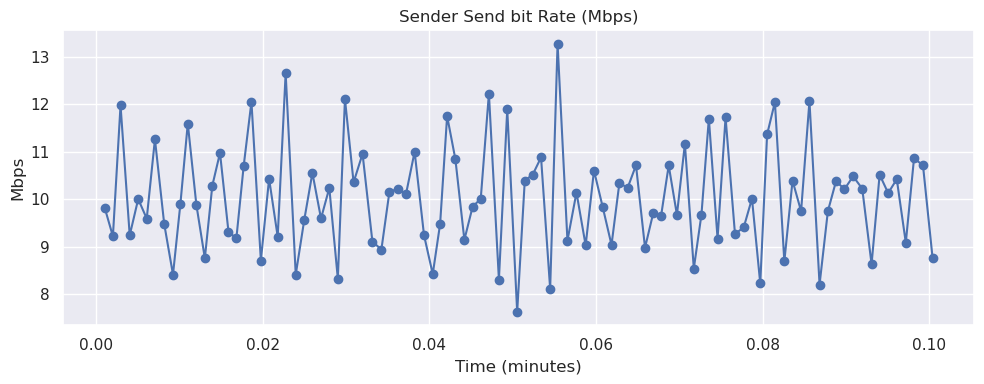

In [22]:
#Plot for Sender = component 0

sim_tm_uS = sentFrms_df.loc[sentFrms_df["component"] == 0, "snt_uS"][1:].reset_index(drop=True)
dts_S = u_1*(sentFrms_df.loc[sentFrms_df["component"] == 0, "snt_uS"][1:].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == 0, "snt_uS"][:-1].reset_index(drop=True))
szs_b = sentFrms_df.loc[sentFrms_df["component"] == 0, "frm_sz_b"][1:].reset_index(drop=True)

btRt_Mbps = one_M*szs_b/dts_S
# Display statistics
btRt_stats_Mbps = compute_moments(btRt_Mbps)

print(f"Component {0} Send Delta Statistics:")
for k, v in btRt_stats_Mbps.items():
    print(f"{k}: {v:.3f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
plt.title(f"Sender Send bit Rate (Mbps)")
plt.xlabel('Time (minutes)')
plt.ylabel('Mbps')
#plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
plt.grid(True)
plt.tight_layout()
plt.show()


Component 1 Send Bit Rate Statistics:
count: 99.000
mean: 10.104
std: 0.712
skew: 0.211
kurtosis: -0.254


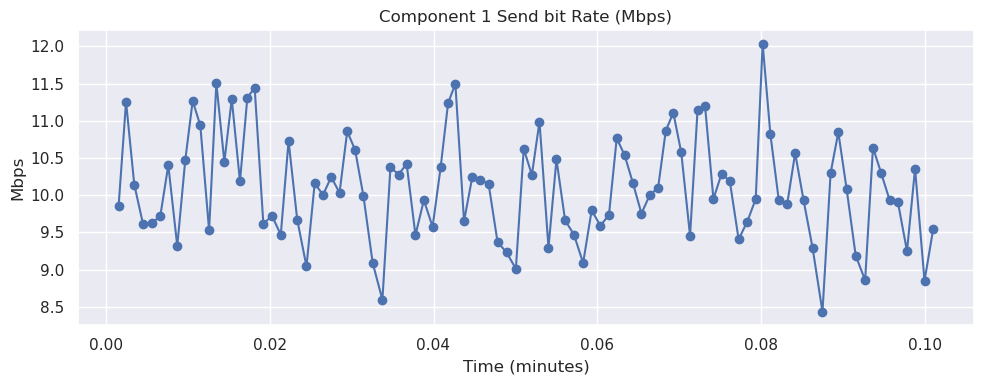

Component 2 Send Bit Rate Statistics:
count: 99.000
mean: 10.133
std: 0.867
skew: 0.607
kurtosis: 0.361


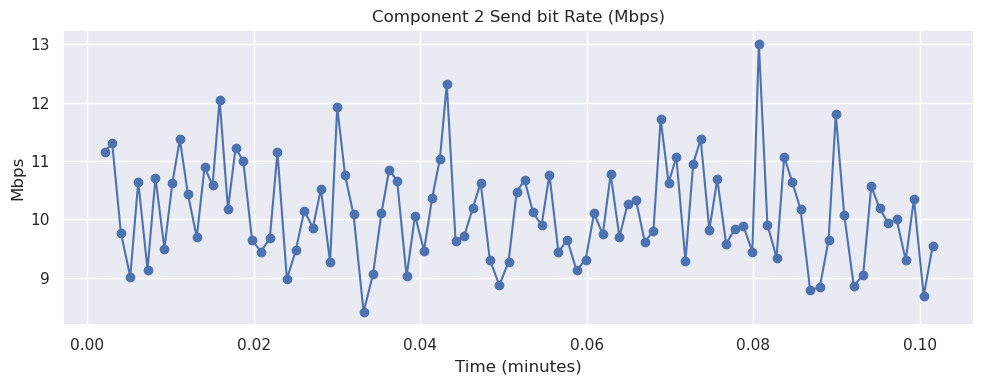

Component 3 Send Bit Rate Statistics:
count: 99.000
mean: 10.185
std: 1.131
skew: 1.102
kurtosis: 1.550


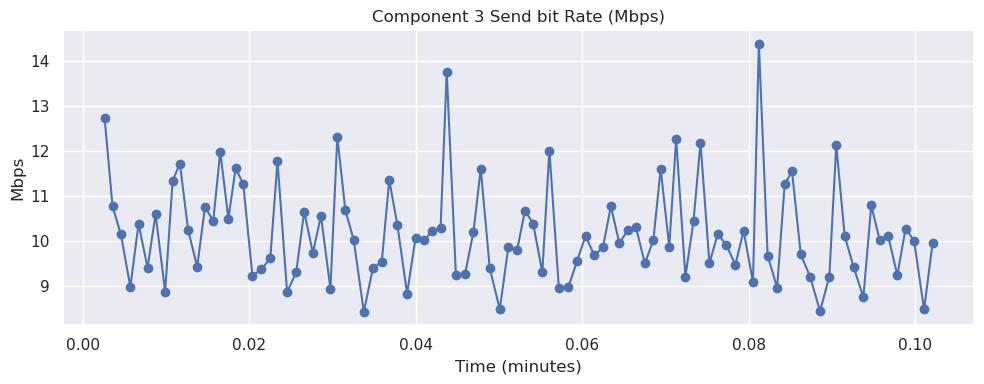

Component 4 Send Bit Rate Statistics:
count: 99.000
mean: 10.234
std: 1.400
skew: 1.445
kurtosis: 2.662


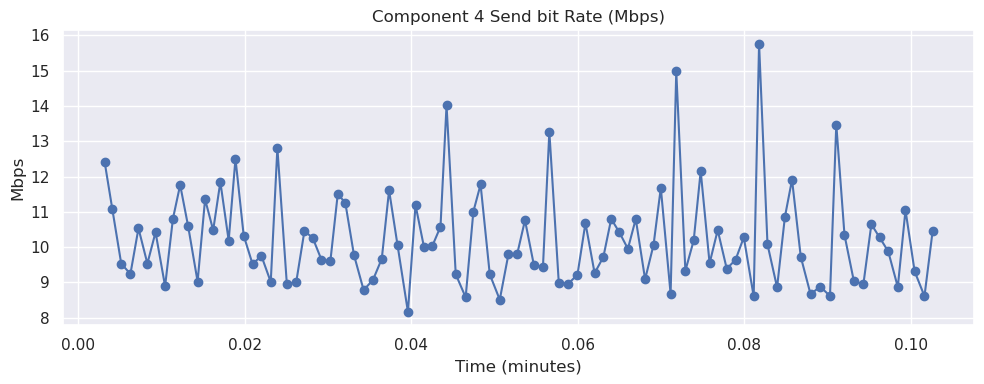

Component 5 Send Bit Rate Statistics:
count: 99.000
mean: 10.253
std: 1.512
skew: 1.784
kurtosis: 4.619


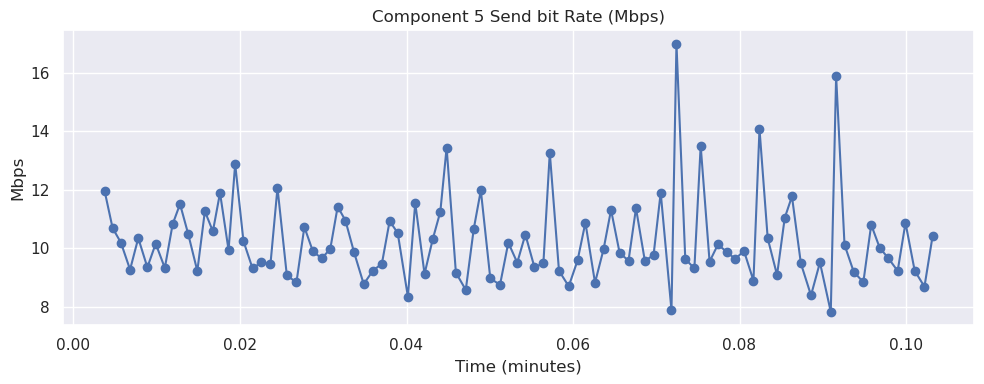

In [23]:
#Plot for Components - last component does not send
for index, cmpnt_id in enumerate(cmpnt_ids[:-1]):

    sim_tm_uS = sentFrms_df.loc[sentFrms_df["component"] == index+1, "snt_uS"][1:].reset_index(drop=True)
    dts_S = u_1*(sentFrms_df.loc[sentFrms_df["component"] == index+1, "snt_uS"][1:].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == index+1, "snt_uS"][:-1].reset_index(drop=True))
    szs_b = sentFrms_df.loc[sentFrms_df["component"] == index+1, "frm_sz_b"][1:].reset_index(drop=True)

    btRt_Mbps = one_M*szs_b/dts_S
    # Display statistics
    btRt_stats_Mbps = compute_moments(btRt_Mbps)

    print(f"Component {index+1} Send Bit Rate Statistics:")
    for k, v in btRt_stats_Mbps.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    plt.title(f"Component {index+1} Send bit Rate (Mbps)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Mbps')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Frame Rate Statistics:
count: 99.000
mean: 16.543
std: 1.347
skew: 0.212
kurtosis: 0.053


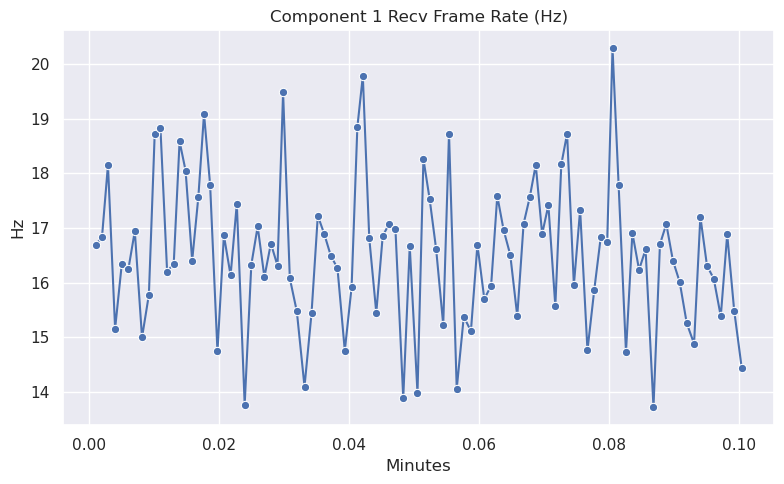

Component 2 Frame Rate Statistics:
count: 99.000
mean: 16.511
std: 1.159
skew: 0.212
kurtosis: -0.239


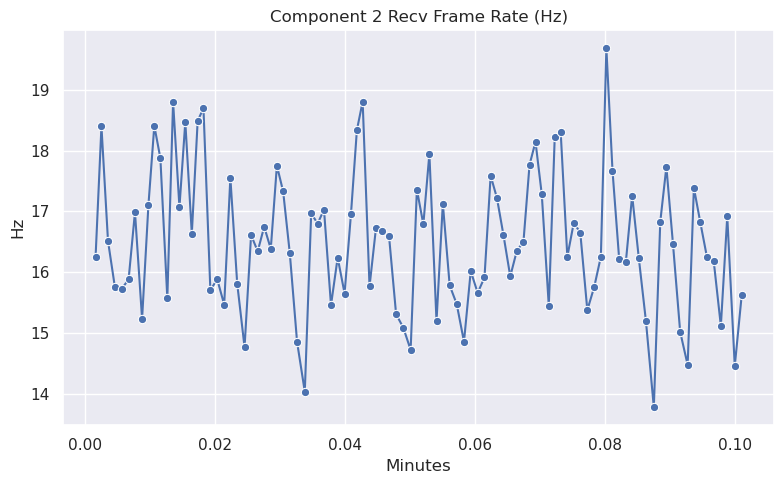

Component 3 Frame Rate Statistics:
count: 99.000
mean: 16.558
std: 1.411
skew: 0.607
kurtosis: 0.355


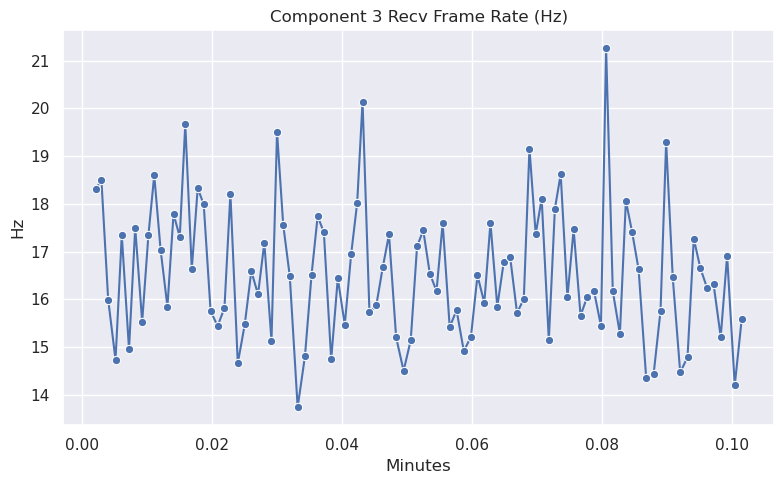

Component 4 Frame Rate Statistics:
count: 99.000
mean: 16.642
std: 1.841
skew: 1.108
kurtosis: 1.565


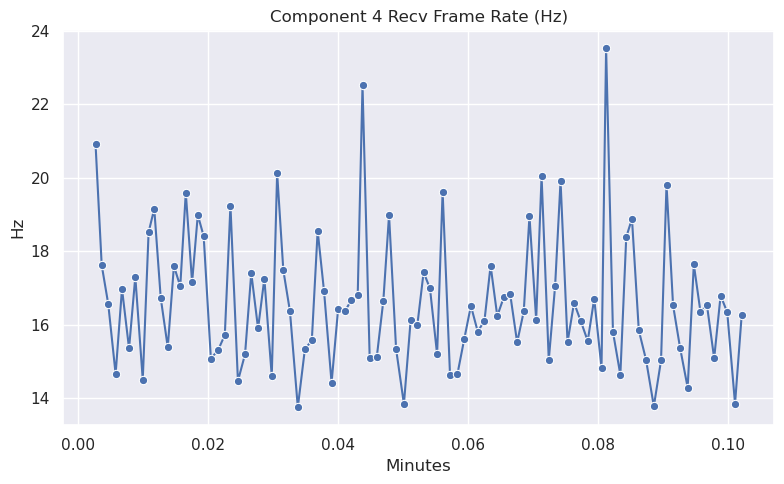

Component 5 Frame Rate Statistics:
count: 99.000
mean: 16.724
std: 2.282
skew: 1.448
kurtosis: 2.674


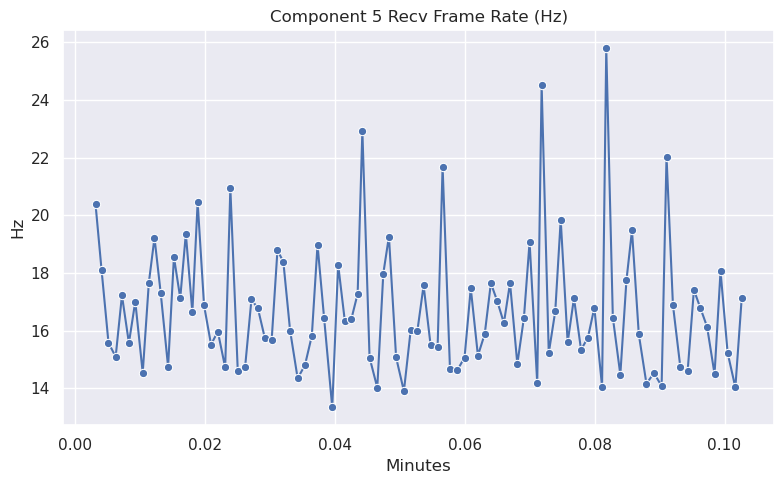

Component 6 Frame Rate Statistics:
count: 99.000
mean: 16.754
std: 2.461
skew: 1.782
kurtosis: 4.604


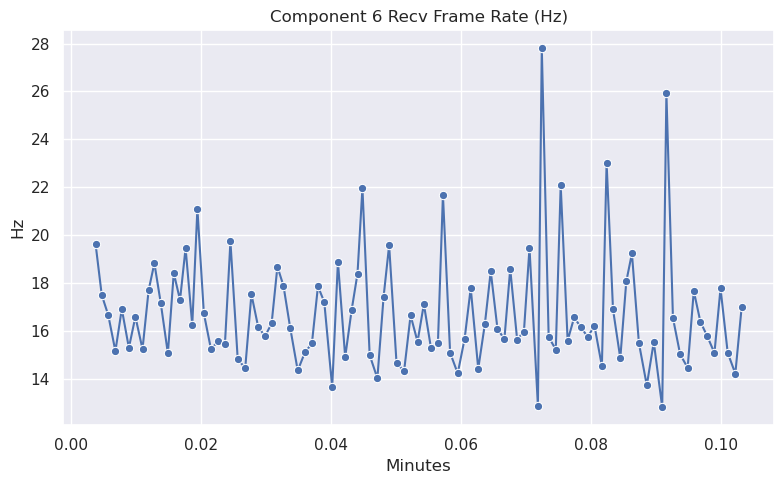

In [24]:
#Plot for Components - Recv Frame Rate
for index, cmpnt_id in enumerate(cmpnt_ids):
    dt_S_arr           = np.diff(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"])
    frame_rates_Hz_arr = 1/dt_S_arr

    # Display statistics
    frame_rate_stats = compute_moments(frame_rates_Hz_arr)

    print(f"Component {index+1} Frame Rate Statistics:")
    for k, v in frame_rate_stats.items():
        print(f"{k}: {v:.3f}")

    # Plot Frame Rate
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))

    timestamps_S_arr = u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"][1:]

    sns.lineplot(x=timestamps_S_arr/60.0, y=frame_rates_Hz_arr, marker="o")       # line + markers
    # —or using pure matplotlib:
    # plt.plot(x, y, marker='o', linestyle='-')

    plt.title(f"Component {index+1} Recv Frame Rate (Hz)")
    plt.xlabel("Minutes")
    plt.ylabel("Hz")
    plt.tight_layout()
    plt.show()

    # plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # plt.title(f"Component {index} Recv Frame Delta (uS)")
    # plt.xlabel("Minutes")
    # plt.ylabel("mS")
    # plt.tight_layout()
    # plt.show()


In [25]:
z = prcsdFrms_df.loc[prcsdFrms_df["component"] == 2,  "rcd_uS"]

In [26]:
print(z[:5].diff())

100        NaN
101    61553.0
102    54355.0
103    60560.0
104    63467.0
Name: rcd_uS, dtype: float64


In [27]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    print(f"index = {index}, cmpnt_id = {cmpnt_id}")

index = 0, cmpnt_id = 6001
index = 1, cmpnt_id = 6002
index = 2, cmpnt_id = 6003
index = 3, cmpnt_id = 6004
index = 4, cmpnt_id = 6005
index = 5, cmpnt_id = 6006


Component 1 Recv Delta Statistics:
count: 99.000
mean: 27.820
std: 2.876
skew: 0.302
kurtosis: 0.147


<Figure size 800x500 with 0 Axes>

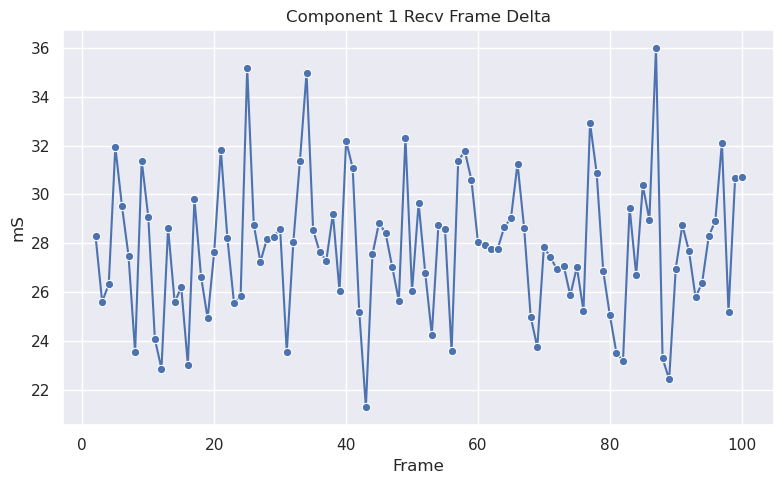

Component 2 Recv Delta Statistics:
count: 99.000
mean: 27.198
std: 4.515
skew: -0.024
kurtosis: -0.432


<Figure size 800x500 with 0 Axes>

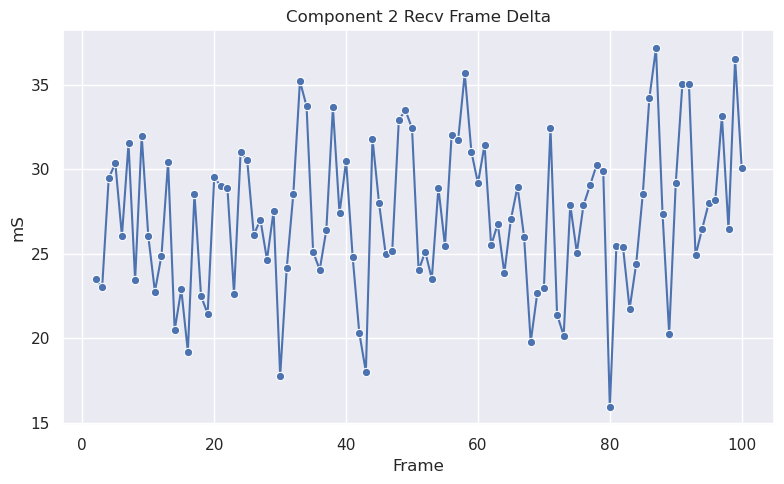

Component 3 Recv Delta Statistics:
count: 99.000
mean: 27.035
std: 5.769
skew: -0.361
kurtosis: 0.079


<Figure size 800x500 with 0 Axes>

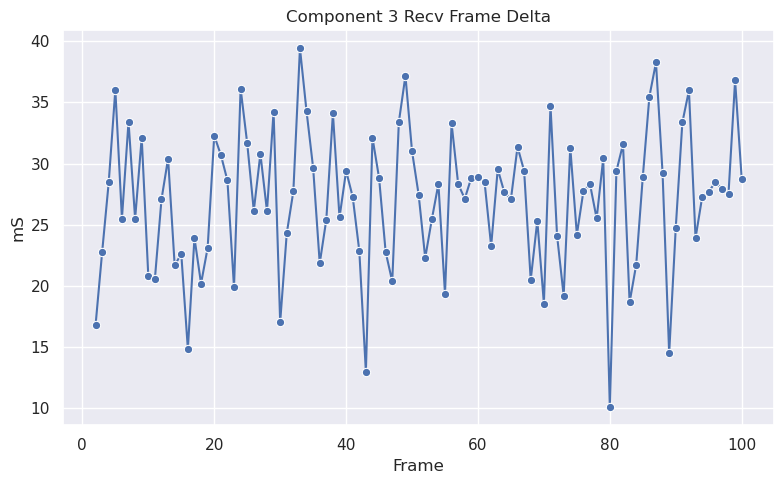

Component 4 Recv Delta Statistics:
count: 99.000
mean: 27.341
std: 6.818
skew: -0.740
kurtosis: 0.537


<Figure size 800x500 with 0 Axes>

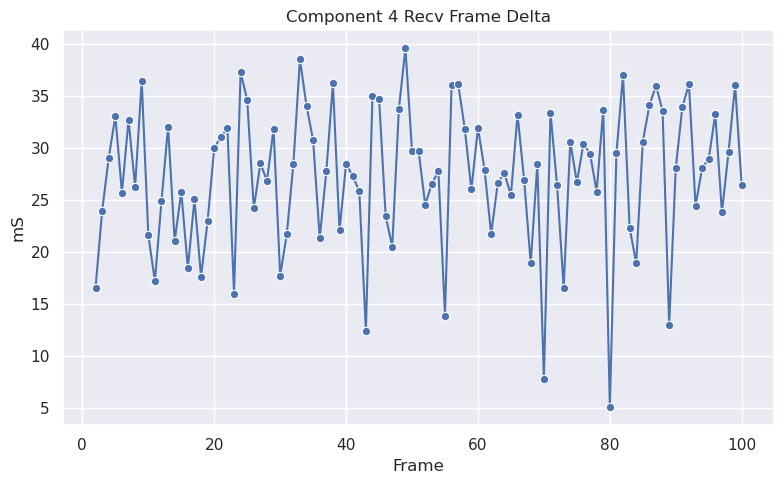

Component 5 Recv Delta Statistics:
count: 99.000
mean: 27.260
std: 7.452
skew: -0.877
kurtosis: 0.969


<Figure size 800x500 with 0 Axes>

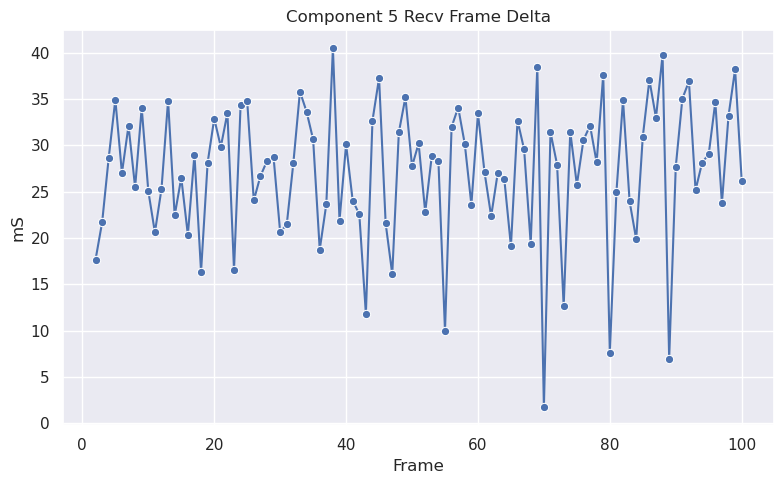

Component 6 Recv Delta Statistics:
count: 99.000
mean: 27.425
std: 7.742
skew: -0.374
kurtosis: 0.486


<Figure size 800x500 with 0 Axes>

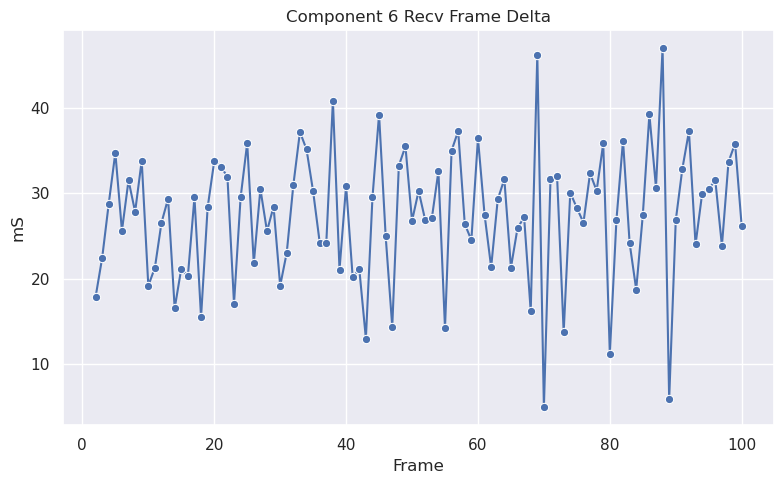

In [28]:
#Plot for Components - Recv Frame Delta Time
for index, cmpnt_id in enumerate(cmpnt_ids):

    plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # sns.lineplot(x=df.loc[df["component"] == i, "frm_nm"][1:], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers

    rcd_uS =  prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1,  "rcd_uS"][1:].reset_index(drop=True)
    done_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "done_uS"][:-1].reset_index(drop=True)

    # print(i)
    # print(rcd)
    # print(done)

    delta_mS = u_m*(rcd_uS - done_uS)

    # Display statistics
    delta_stats_mS = compute_moments(delta_mS)

    print(f"Component {index+1} Recv Delta Statistics:")
    for k, v in delta_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # print(diff)
    # print(df.loc[df["component"] == i, "frm_nm"][1:])
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"][1:].reset_index(drop=True), y=delta_mS , marker="o")       # line + markers
    plt.title(f"Component {index+1} Recv Frame Delta")
    plt.xlabel("Frame")
    plt.ylabel("mS")
    plt.tight_layout()
    plt.show()



In [29]:
prcsdFrms_df.loc[prcsdFrms_df["component"] == 1, "rcd_uS"].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == 0, "snt_uS"].reset_index(drop=True)

0     962.0
1     514.0
2     453.0
3     568.0
4     444.0
      ...  
95    481.0
96    474.0
97    487.0
98    548.0
99    446.0
Length: 100, dtype: float64

Component 1 Recv Delta Statistics:
count: 99.000
mean: 0.481
std: 0.030
skew: 1.422
kurtosis: 2.660


<Figure size 800x500 with 0 Axes>

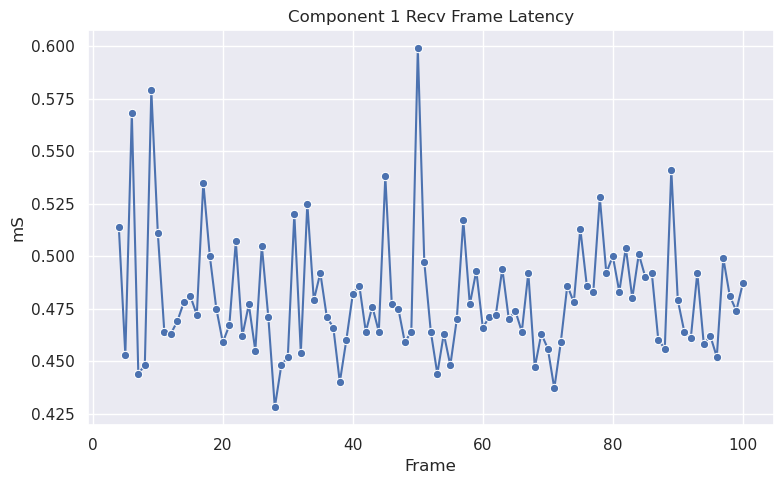

Component 2 Recv Delta Statistics:
count: 99.000
mean: 0.266
std: 0.027
skew: 2.638
kurtosis: 13.366


<Figure size 800x500 with 0 Axes>

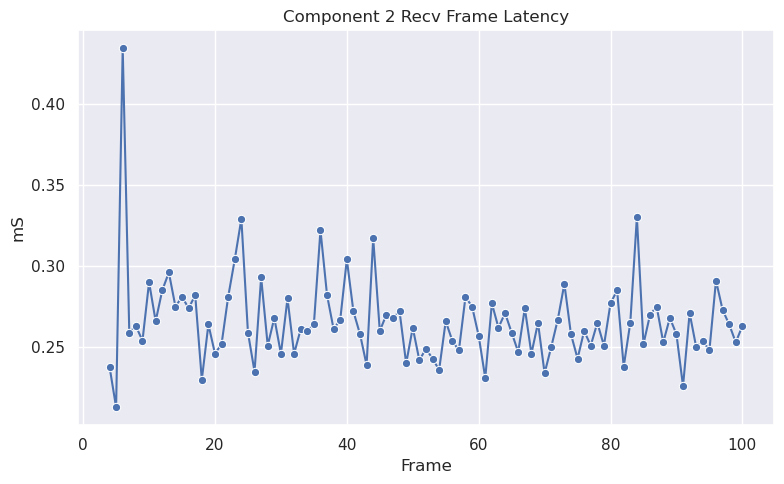

Component 3 Recv Delta Statistics:
count: 99.000
mean: 0.232
std: 0.028
skew: 0.889
kurtosis: 2.240


<Figure size 800x500 with 0 Axes>

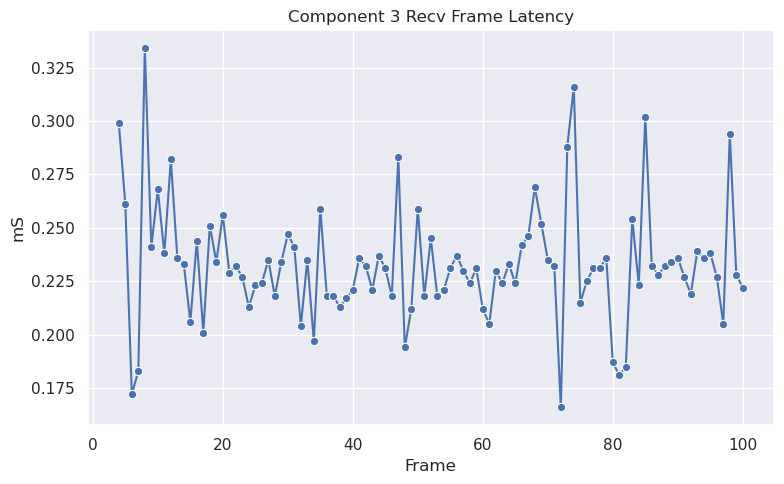

Component 4 Recv Delta Statistics:
count: 99.000
mean: 0.496
std: 0.041
skew: 5.569
kurtosis: 42.987


<Figure size 800x500 with 0 Axes>

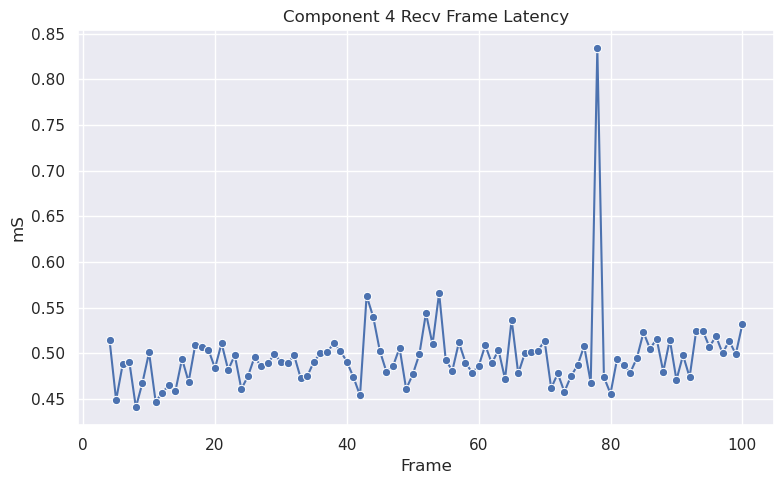

Component 5 Recv Delta Statistics:
count: 99.000
mean: 0.156
std: 0.030
skew: 1.515
kurtosis: 5.196


<Figure size 800x500 with 0 Axes>

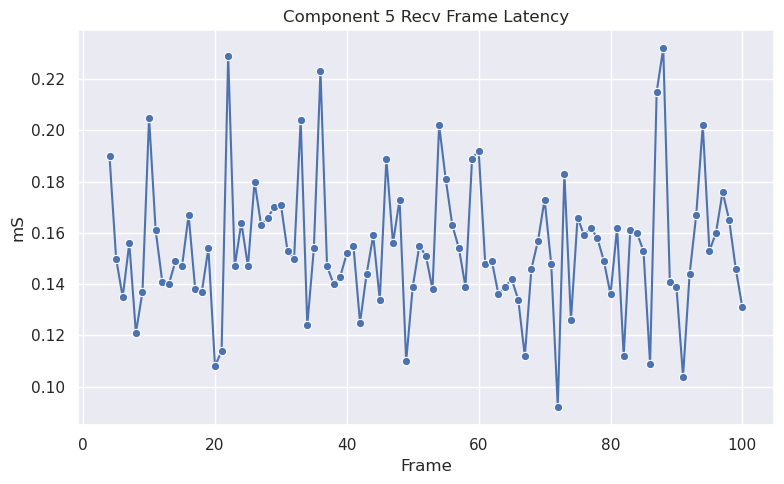

Component 6 Recv Delta Statistics:
count: 99.000
mean: 0.372
std: 0.028
skew: -0.567
kurtosis: 0.549


<Figure size 800x500 with 0 Axes>

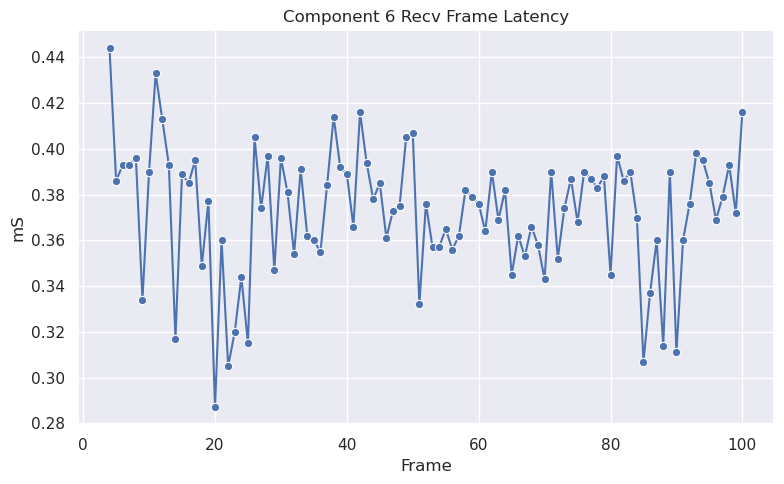

In [30]:
#Plot for Components - Recv Frame Delta Time

for index, cmpnt_id in enumerate(cmpnt_ids):

    plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # sns.lineplot(x=df.loc[df["component"] == i, "frm_nm"][1:], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers

    ltnc_mS = u_m*(prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == index, "snt_uS"].reset_index(drop=True))

    # Display statistics
    ltnc_stats_mS = compute_moments(ltnc_mS[1:])

    print(f"Component {index+1} Recv Delta Statistics:")
    for k, v in ltnc_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # print(diff)
    # print(df.loc[df["component"] == i, "frm_nm"][1:])
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"][2:].reset_index(drop=True), y=ltnc_mS[1:] , marker="o")       # line + markers
    plt.title(f"Component {index+1} Recv Frame Latency")
    plt.xlabel("Frame")
    plt.ylabel("mS")
    plt.tight_layout()
    plt.show()



In [31]:
prcsdFrms_df.loc[prcsdFrms_df["component"] == 2, "frm_sz_b"].mean()

np.float64(612230.0)

In [32]:
# Network thruput in Gbps
one_G*prcsdFrms_df.loc[prcsdFrms_df["component"] == 2, "frm_sz_b"].mean()/(0.5*m_1)

np.float64(1.22446)

In [33]:
# Network thruput in Gbps
one_G*60*sz1K*B_b/(0.5*m_1)

1.2288000000000001

Component 1 Recv Delta Statistics:
count: 99.000
mean: 10.037
std: 1.134
skew: 0.385
kurtosis: -0.180


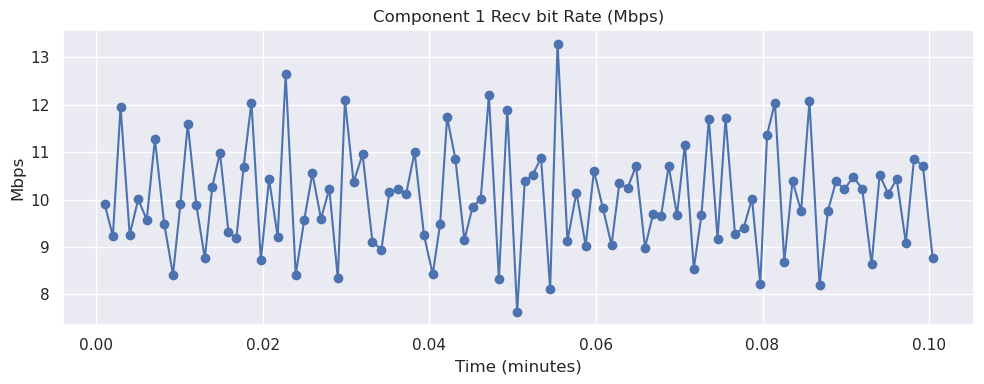

Component 2 Recv Delta Statistics:
count: 99.000
mean: 10.109
std: 0.713
skew: 0.212
kurtosis: -0.239


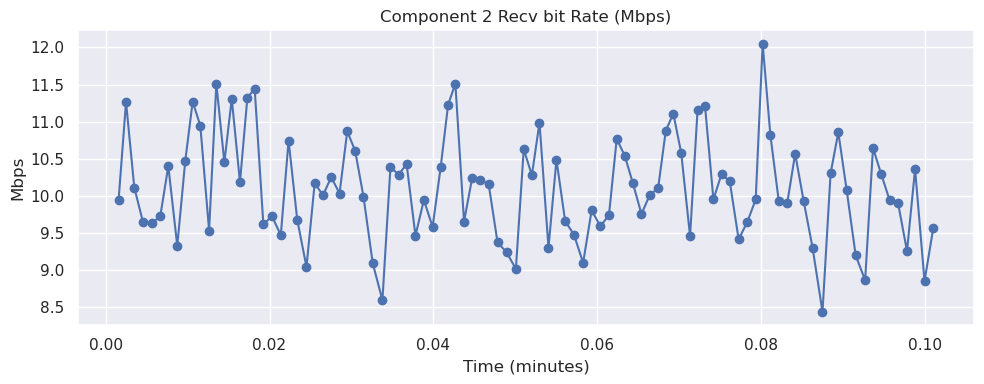

Component 3 Recv Delta Statistics:
count: 99.000
mean: 10.137
std: 0.868
skew: 0.607
kurtosis: 0.355


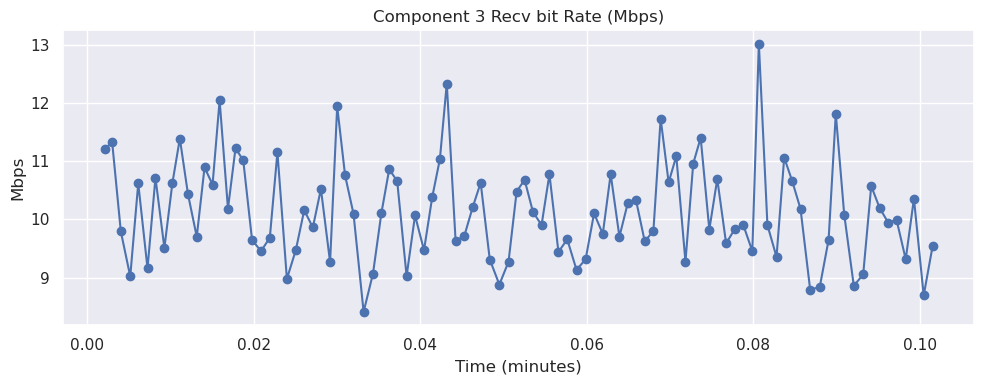

Component 4 Recv Delta Statistics:
count: 99.000
mean: 10.189
std: 1.133
skew: 1.108
kurtosis: 1.565


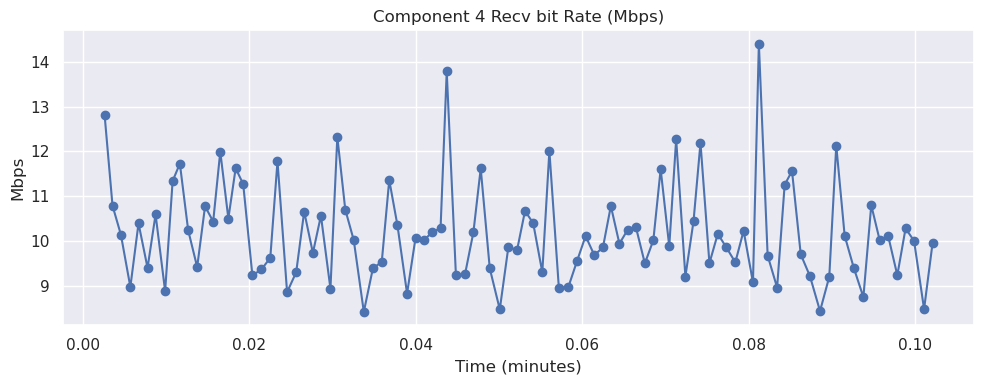

Component 5 Recv Delta Statistics:
count: 99.000
mean: 10.239
std: 1.404
skew: 1.448
kurtosis: 2.674


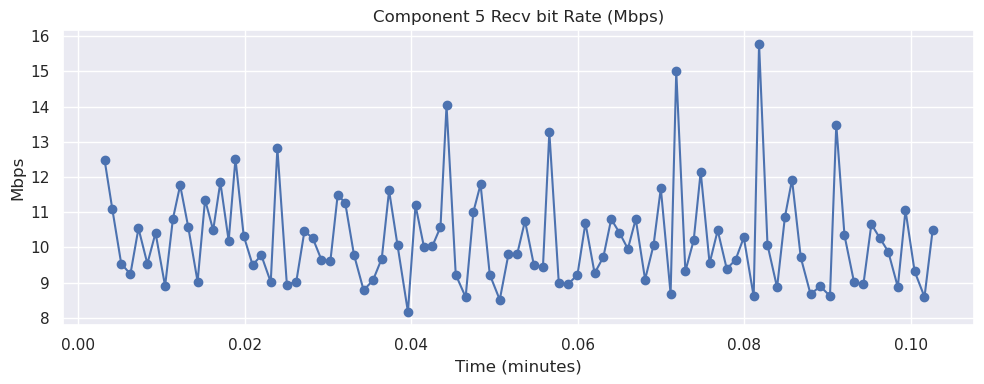

Component 6 Recv Delta Statistics:
count: 99.000
mean: 10.257
std: 1.515
skew: 1.782
kurtosis: 4.604


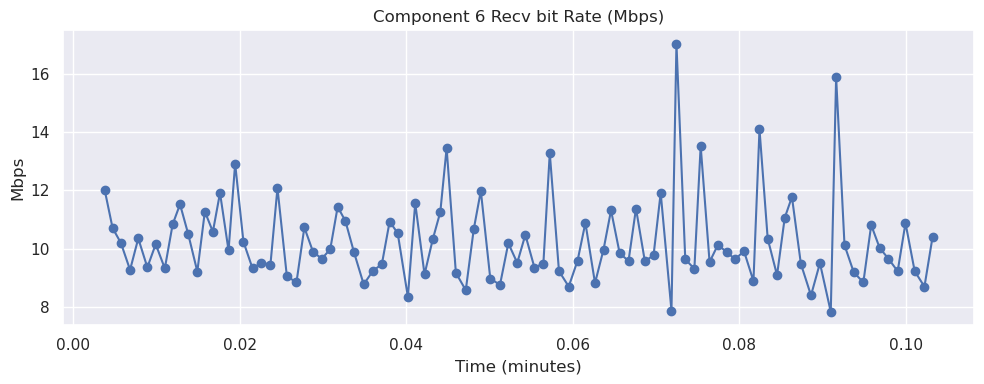

In [34]:
#Plot for Components - Recv Bit Rate
for index, cmpnt_id in enumerate(cmpnt_ids):

    sim_tm_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"][1:].reset_index(drop=True)
    dts_S = u_1*(prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"][1:].reset_index(drop=True) - prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"][:-1].reset_index(drop=True))
    szs_b = prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_sz_b"][1:].reset_index(drop=True)

    btRt_Mbps = one_M*szs_b/dts_S
    # Display statistics
    btRt_stats_Mbps = compute_moments(btRt_Mbps)

    print(f"Component {index+1} Recv Delta Statistics:")
    for k, v in btRt_stats_Mbps.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    plt.title(f"Component {index+1} Recv bit Rate (Mbps)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Mbps')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Recv Delta Statistics:
count: 100.000
mean: 33.031
std: 3.133
skew: 0.316
kurtosis: 0.152


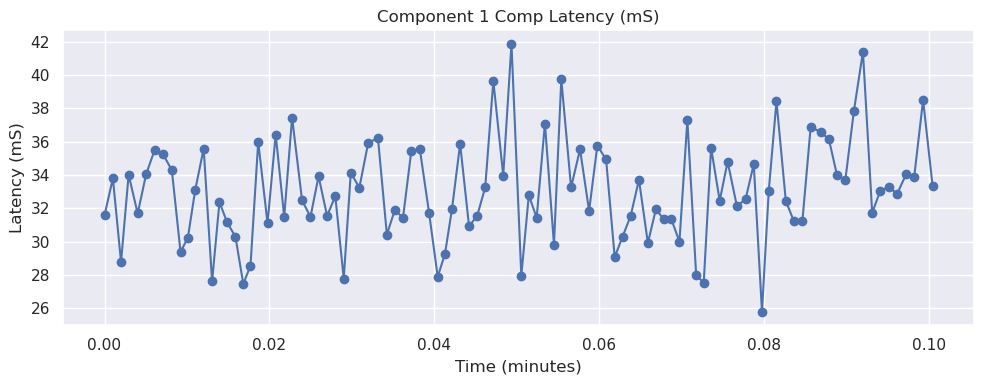

Component 2 Recv Delta Statistics:
count: 100.000
mean: 33.665
std: 1.890
skew: 0.801
kurtosis: 0.443


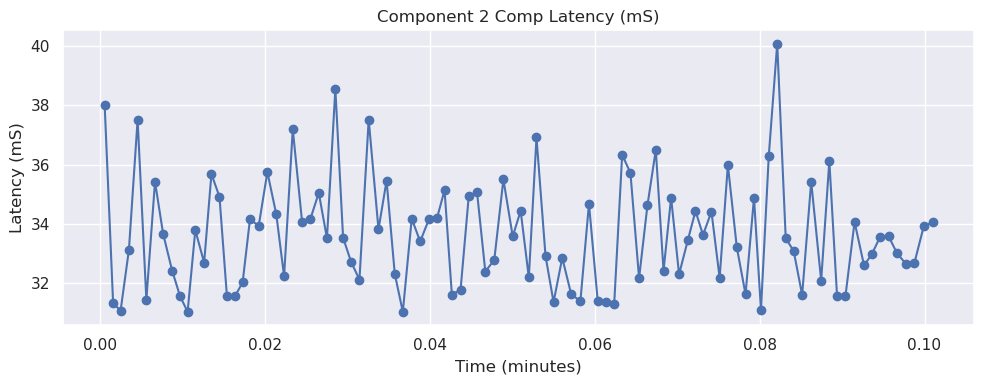

Component 3 Recv Delta Statistics:
count: 100.000
mean: 33.771
std: 1.989
skew: 0.600
kurtosis: -0.338


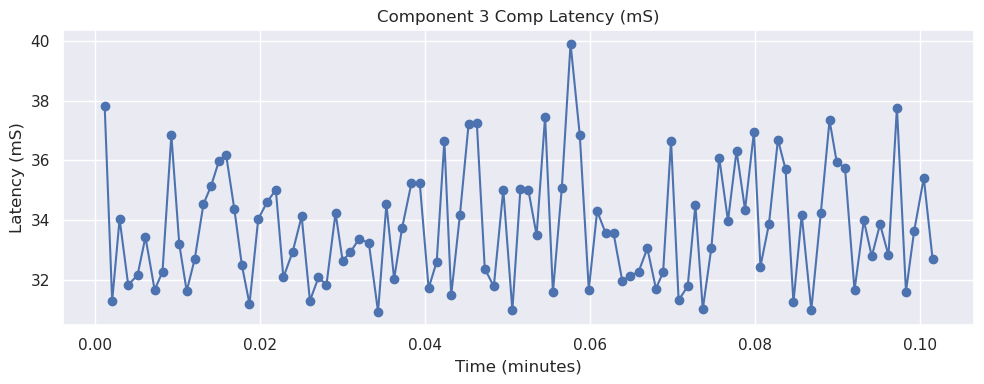

Component 4 Recv Delta Statistics:
count: 100.000
mean: 33.408
std: 1.967
skew: 1.417
kurtosis: 2.836


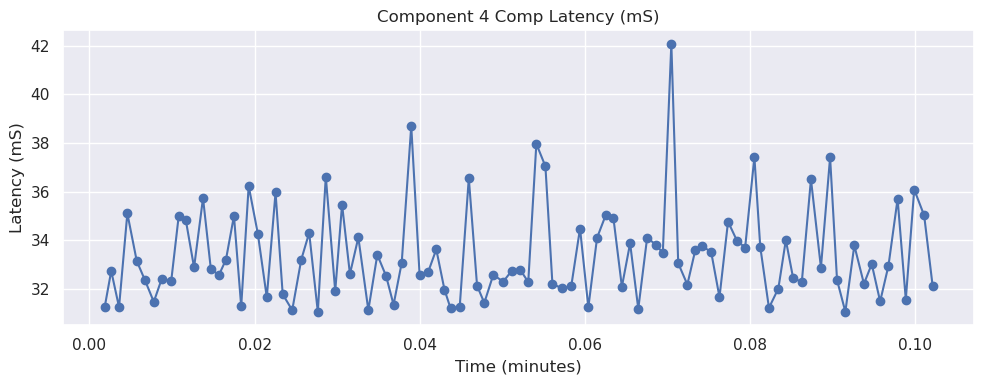

Component 5 Recv Delta Statistics:
count: 100.000
mean: 33.498
std: 1.882
skew: 0.717
kurtosis: -0.110


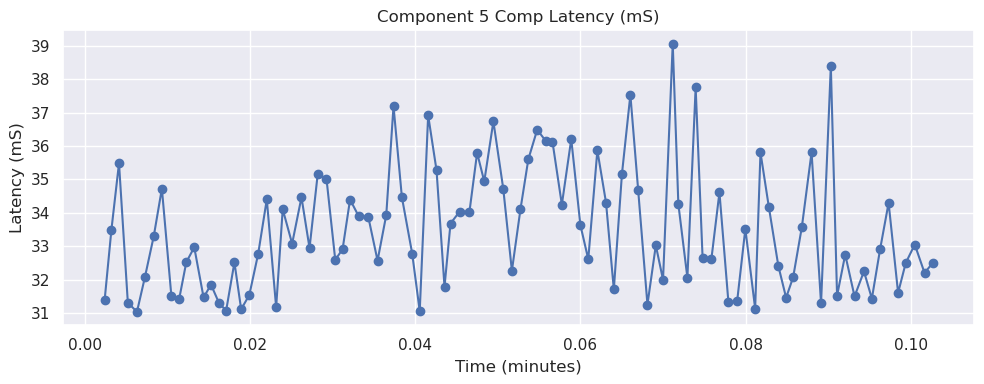

Component 6 Recv Delta Statistics:
count: 100.000
mean: 33.346
std: 2.030
skew: 1.092
kurtosis: 0.327


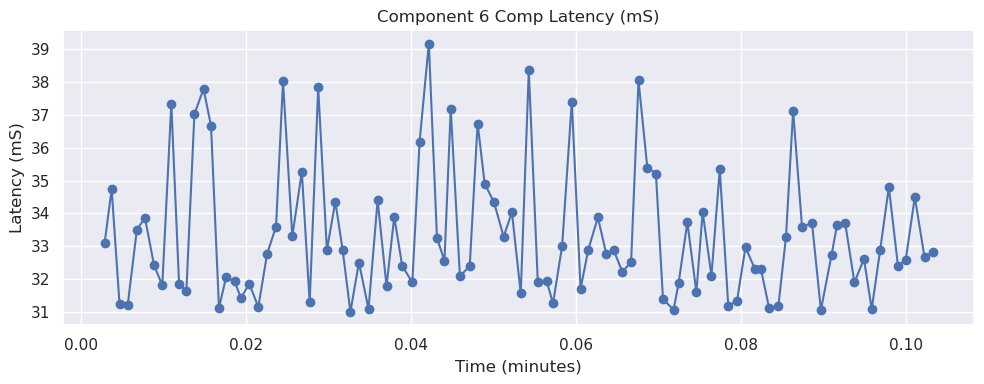

In [35]:
#Plot for Components - Comp Latency
for index, cmpnt_id in enumerate(cmpnt_ids):

    cmpLt_mS = u_m*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "cmp_ltnc_uS"]
    # Display statistics
    cmpLt_stats_mS = compute_moments(cmpLt_mS)

    print(f"Component {index+1} Recv Delta Statistics:")
    for k, v in cmpLt_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"]/60, cmpLt_mS, marker='o', linestyle='-')
    plt.title(f"Component {index+1} Comp Latency (mS)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (mS)')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

In [36]:
# #Plot for Components - Network Latency
# for index, cmpnt_id in enumerate(cmpnt_ids):

#     ntwrkLt_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "ntwrk_lt_uS"]
#     # Display statistics
#     ntwrkLt_stats_uS = compute_moments(ntwrkLt_uS)

#     print(f"Component {index+1} Recv Delta Statistics:")
#     for k, v in ntwrkLt_stats_uS.items():
#         print(f"{k}: {v:.3f}")

#     # Plot
#     plt.figure(figsize=(10, 4))
#     plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"]/60, ntwrkLt_uS, marker='o', linestyle='-')
#     plt.title(f"Component {index+1} Network Latency (uS)")
#     plt.xlabel('Time (minutes)')
#     plt.ylabel('Latency (uS)')
#     #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # print(recd.tail(5))

#     # recd.drop(recd.index, inplace=True)

#     # print(recd.tail(5))

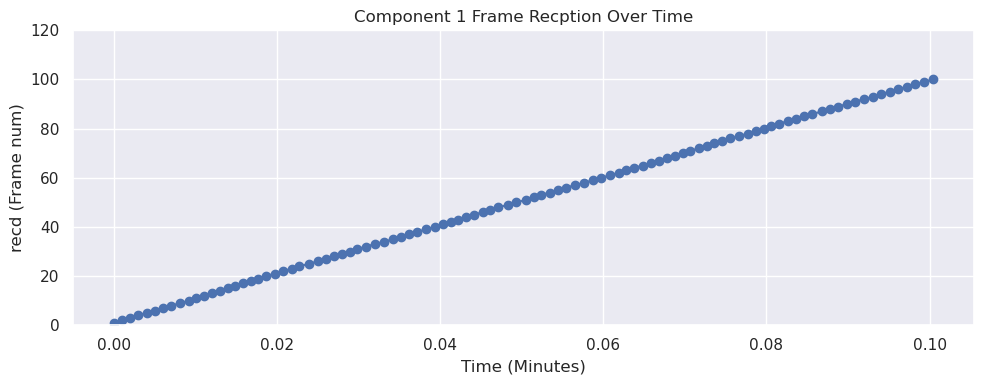

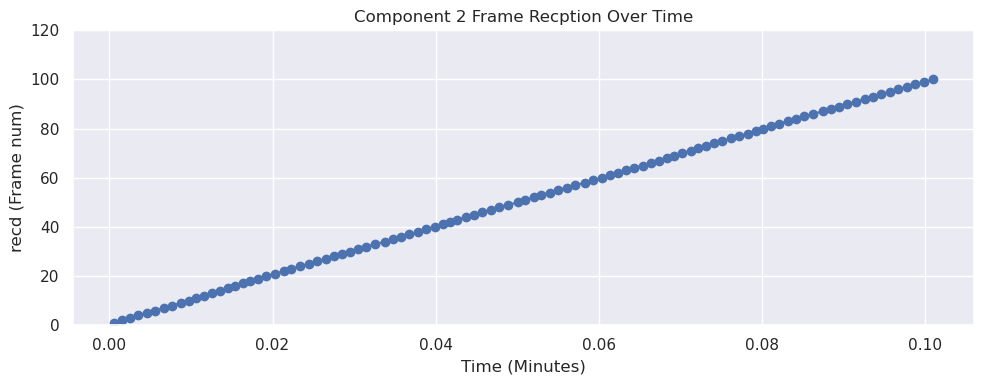

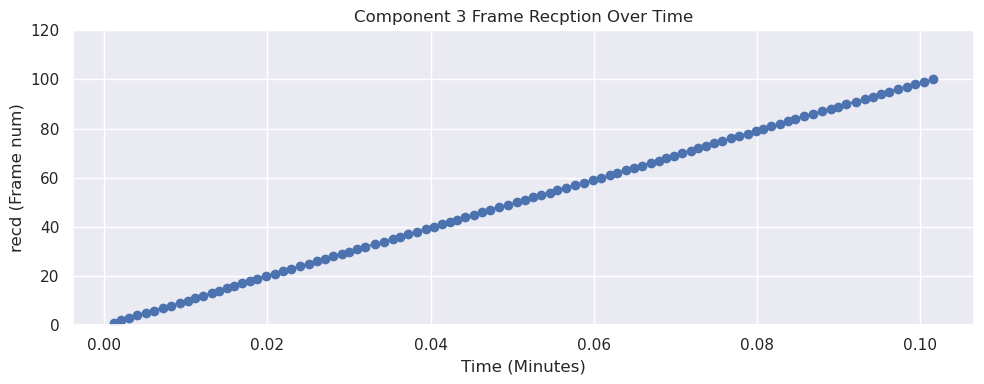

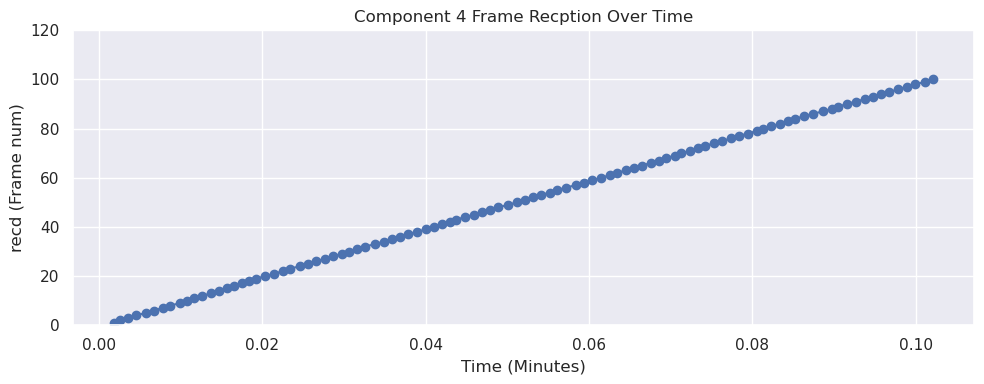

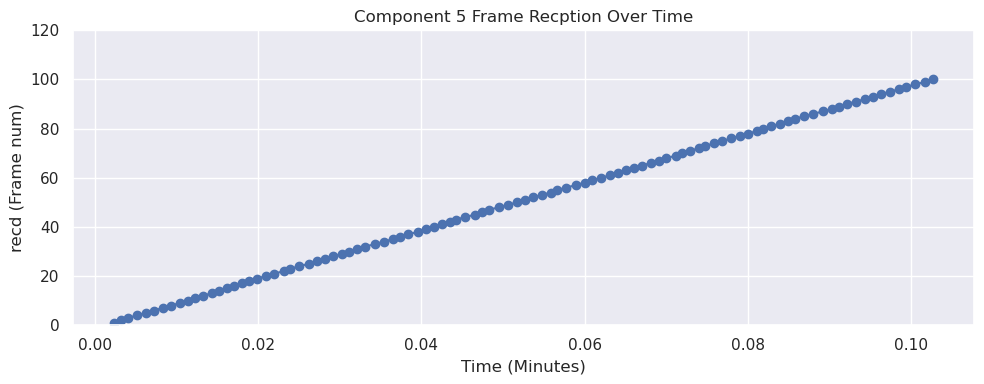

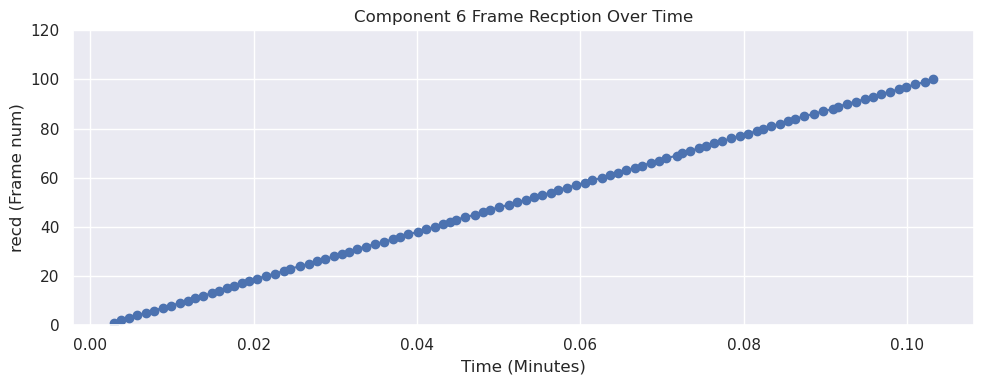

In [37]:
#Plot for Components - Recvd Frames
for index, cmpnt_id in enumerate(cmpnt_ids):
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"], marker='o', linestyle='-')
    plt.title(f"Component {index+1} Frame Recption Over Time")
    plt.xlabel('Time (Minutes)')
    plt.ylabel('recd (Frame num)')
    plt.ylim(0, max(prcsdFrms_df['frm_nm']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


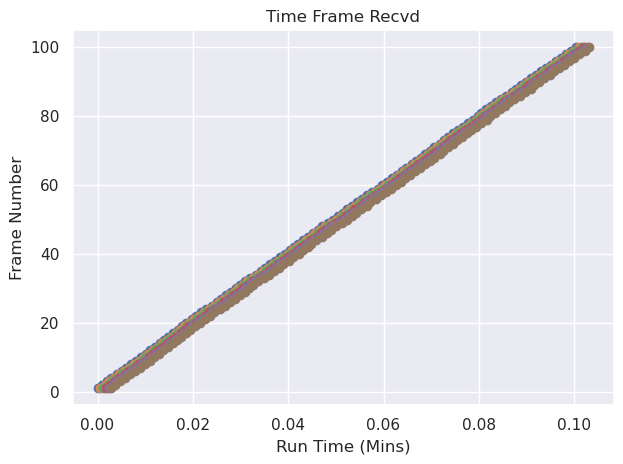

In [38]:
#Plot for Components - Recvd Frame Time
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Plot
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"], marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Run Time (Mins)')
plt.ylabel('Frame Number')
plt.title('Time Frame Recvd')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


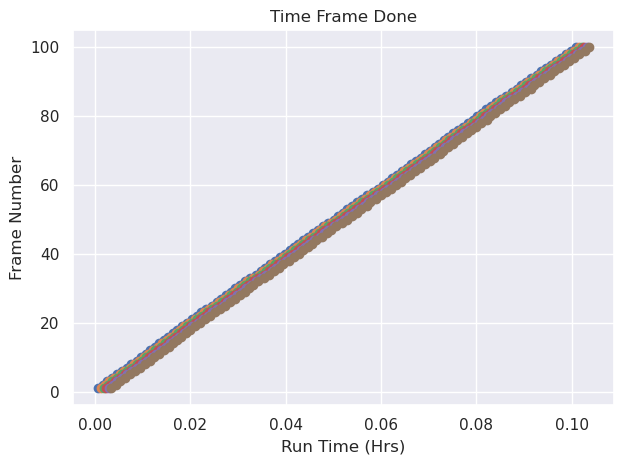

In [39]:
#Plot for Components - Frame Done
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Plot
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "done_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"], marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Run Time (Hrs)')
plt.ylabel('Frame Number')
plt.title('Time Frame Done')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
drpmsdFrms_df.head(5)

,component,rcd_uS,frm_nm,frm_sz_b,lstDone_uS


In [41]:
drp_sets_by_component = drpmsdFrms_df.groupby("component")["frm_nm"].apply(set)
cmpnt_drp_nms = set(drpmsdFrms_df["component"].unique())
for c in cmpnt_drp_nms:
    print(f"Number of drops for component {c}: {len(drp_sets_by_component[c])}")

In [42]:
drp_sets_by_component

Series([], Name: frm_nm, dtype: int64)

In [43]:
cmpnt_drp_nms

set()

In [44]:
prcsd_frm_sets_by_component = prcsdFrms_df.groupby("component")["frm_nm"].apply(set)
cmpnt_frn_nms = set(prcsdFrms_df["component"].unique())
for c in cmpnt_frn_nms:
    print(f"Number of processed frames for component {c}: {len(prcsd_frm_sets_by_component[c])}")

Number of processed frames for component 1: 100
Number of processed frames for component 2: 100
Number of processed frames for component 3: 100
Number of processed frames for component 4: 100
Number of processed frames for component 5: 100
Number of processed frames for component 6: 100


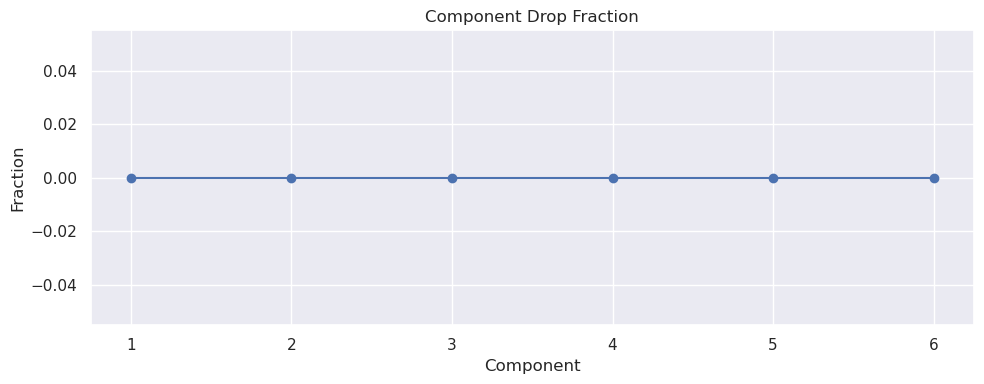

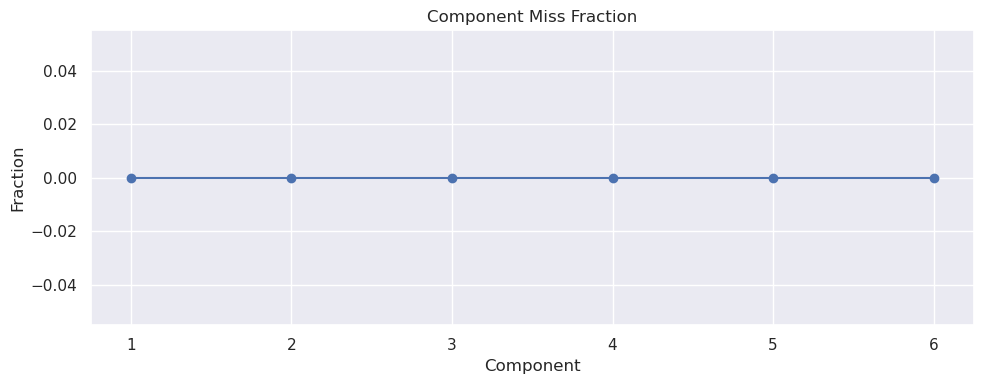

In [45]:
#Plot for Components - Dropped/Missed Frames
cmpnt_cnt = len(cmpnt_ids)
drpdFrmsFrctn_df = pd.DataFrame({
    "component": pd.Series(dtype=int),
    "drp_frctn":   pd.Series(dtype=int)
})

cmpnt_drp_nms = set(drpmsdFrms_df["component"].unique())
#dataframe record for components with no drops
# for index, cmpnt_id in enumerate(cmpnt_ids):
for c in set(range(1,cmpnt_cnt+1)) - cmpnt_drp_nms: #the set of compnents with no drops
    row = (c,0)
    drpdFrmsFrctn_df = pd.concat([drpdFrmsFrctn_df, pd.DataFrame([row], columns=drpdFrmsFrctn_df.columns)], ignore_index=True)
    
#dataframe record for components with drops
drp_sets_by_component = drpmsdFrms_df.groupby("component")["frm_nm"].apply(set)
# for index, cmpnt_id in enumerate(cmpnt_ids):
for c in cmpnt_drp_nms:
    row = (c,len(drp_sets_by_component[c])/(len(drp_sets_by_component[c]) + len(prcsd_frm_sets_by_component[c])))
    drpdFrmsFrctn_df = pd.concat([drpdFrmsFrctn_df, pd.DataFrame([row], columns=drpdFrmsFrctn_df.columns)], ignore_index=True)

# drpdFrmsFrctn_df

# Plot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

x = drpdFrmsFrctn_df['component'].astype(int)
y = drpdFrmsFrctn_df['drp_frctn']
max_y = np.nanmax(y) if len(y) else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, marker='o', linestyle='-')
ax.set_title("Component Drop Fraction")
ax.set_xlabel("Component")
ax.set_ylabel("Fraction")
# ax.set_ylim(-0.01, max_y * 1.2)

# Force integer tick locations
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
fig.tight_layout()
plt.show()

#Frames that components missed because they were never received
msdFrmsFrctn_df = pd.DataFrame({
    "component": pd.Series(dtype=int),
    "msd_frctn": pd.Series(dtype=int)
})

#Compnents miss frames when upstream senders do not send
#Upstrean components do not send frames they miss or drop
#The effect is cummulative for downstream components

#For each component, This equates to the number of sender frames - (number processd + the number droped (since they were not missed))

# for index, cmpnt_id in enumerate(cmpnt_ids):
#     row = (int(index+1),1-(len(set(prcsdFrms_df.loc[prcsdFrms_df["component"] == int(index+1), "frm_nm"])) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == int(index+1), "frm_nm"])))/len(all_frm_set))
#     msdFrmsFrctn_df = pd.concat([msdFrmsFrctn_df, pd.DataFrame([row], columns=msdFrmsFrctn_df.columns)], ignore_index=True)

#The first component never misses frames
row = (1,0)
msdFrmsFrctn_df = pd.concat([msdFrmsFrctn_df, pd.DataFrame([row], columns=msdFrmsFrctn_df.columns)], ignore_index=True)

for c in range(2,cmpnt_cnt+1):
    row = (c,1-(len(set(prcsdFrms_df.loc[prcsdFrms_df["component"] == c-1, "frm_nm"])) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c-1, "frm_nm"])))/len(all_frm_set))
    msdFrmsFrctn_df = pd.concat([msdFrmsFrctn_df, pd.DataFrame([row], columns=msdFrmsFrctn_df.columns)], ignore_index=True)

x = msdFrmsFrctn_df['component'].astype(int)
y = msdFrmsFrctn_df['msd_frctn']
ax_y = np.nanmax(y) if len(y) else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, marker='o', linestyle='-')
ax.set_title("Component Miss Fraction")
ax.set_xlabel("Component")
ax.set_ylabel("Fraction")
# ax.set_ylim(-0.01, max_y * 1.2)

# Force integer tick locations
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
fig.tight_layout()
plt.show()


In [46]:
len(all_frm_set)

100

In [47]:
# import yaml
# import subprocess

# class BatchProcessor:
#     def __init__(self, directory=".", extension=".txt"):
#         self.directory = directory
#         self.extension = extension
#         self.config = None   # YAML config
#         self.prog = None     # binary name

#     def emulate(self, file="blah.yaml", prog="xyz"):
#         """
#         Load YAML config and deploy daisy-chained binaries across remote hosts.
#         """
#         try:
#             with open(file, "r") as f:
#                 self.config = yaml.safe_load(f)
#             self.prog = prog
#             print(f"[INFO] Loaded config from {file}")
#         except Exception as e:
#             print(f"[ERROR] Failed to load YAML config: {e}")
#             return

#         try:
#             num_cmpnts = self.config["num-cmpnts"]
#             base_port  = self.config["base-port"]
#             frm_cnt    = self.config["frm_cnt"]
#             frm_sz     = self.config["frm_sz"]
#             bit_rt     = self.config["bit_rt"]
#             ip_list    = self.config["hosts"]
#         except KeyError as e:
#             print(f"[ERROR] Missing required config key: {e}")
#             return

#         current_p = base_port
#         current_r = base_port + 1

#         for idx, ip in enumerate(ip_list):
#             z_val = 1 if idx == len(ip_list) - 1 else 0

#             cmd = [
#                 f"./{prog}",
#                 "-b", "1",            # placeholder latency per GB
#                 "-f", str(frm_cnt),
#                 "-i", ip,
#                 "-m", "1",            # memory footprint GB
#                 "-o", "1",            # output size GB
#                 "-p", str(current_p),
#                 "-r", str(current_r),
#                 "-s", "0",
#                 "-t", "10",
#                 "-v", "0",
#                 "-y", file,
#                 "-z", str(z_val)
#             ]

#             print(f"[INFO] Deploying to {ip}: {' '.join(cmd)}")

#             try:
#                 subprocess.run(
#                     ["scp", prog, f"{ip}:/tmp/{prog}"],
#                     check=True,
#                     stdout=subprocess.PIPE,
#                     stderr=subprocess.PIPE
#                 )
#                 print(f"[INFO] Copied {prog} to {ip}:/tmp/{prog}")
#             except subprocess.CalledProcessError as e:
#                 print(f"[ERROR] Failed to copy binary to {ip}: {e.stderr.decode().strip()}")
#                 continue

#             try:
#                 ssh_cmd = ["ssh", ip, f"chmod +x /tmp/{prog} && /tmp/{prog} {' '.join(cmd[1:])}"]
#                 subprocess.run(
#                     ssh_cmd,
#                     check=True,
#                     stdout=subprocess.PIPE,
#                     stderr=subprocess.PIPE
#                 )
#                 print(f"[INFO] Successfully started {prog} on {ip}")
#             except subprocess.CalledProcessError as e:
#                 print(f"[ERROR] Failed to run {prog} on {ip}: {e.stderr.decode().strip()}")
#                 continue

#             current_p = current_r
#             current_r = current_p + 1

#     def send_emu(self, frm_sz=None, frm_cnt=None, bit_rt=None):
#         """
#         Send emulation command to the *first host* in the config.
#         If no args passed, defaults to YAML values.
#         """
#         if not self.config or not self.prog:
#             print("[ERROR] Config not loaded. Run emulate() first.")
#             return

#         frm_sz  = frm_sz  if frm_sz  is not None else self.config.get("frm_sz")
#         frm_cnt = frm_cnt if frm_cnt is not None else self.config.get("frm_cnt")
#         bit_rt  = bit_rt  if bit_rt  is not None else self.config.get("bit_rt")

#         ip_list = self.config.get("hosts", [])
#         if not ip_list:
#             print("[ERROR] No hosts defined in config.")
#             return

#         first_ip = ip_list[0]

#         # Build command to send
#         cmd = [
#             f"/tmp/{self.prog}",
#             "-f", str(frm_cnt),
#             "-o", str(frm_sz),
#             "-r", str(bit_rt),
#             "-s", "0",
#             "-v", "1"
#         ]

#         print(f"[INFO] Sending emulation from {first_ip}: {' '.join(cmd)}")

#         try:
#             ssh_cmd = ["ssh", first_ip, " ".join(cmd)]
#             subprocess.run(
#                 ssh_cmd,
#                 check=True,
#                 stdout=subprocess.PIPE,
#                 stderr=subprocess.PIPE
#             )
#             print(f"[INFO] Emulation command sent successfully to {first_ip}")
#         except subprocess.CalledProcessError as e:
#             print(f"[ERROR] Failed to send emulation to {first_ip}: {e.stderr.decode().strip()}")




# bp = BatchProcessor()
# bp.emulate(file="blah.yaml", prog="xyz")   # deploys daisy chain
# bp.send_emu(frm_sz=2, frm_cnt=1000, bit_rt=50)  # triggers sender on first host


In [48]:
        # with open(self.config, "r") as f:
        #     data = yaml.safe_load(f)


In [49]:


# import yaml
# import subprocess

# class BatchProcessor:
#     def __init__(self, directory=".", extension=".txt"):
#         self.directory = directory
#         self.extension = extension
#         self.config = None   # YAML config
#         self.prog = None     # binary name

#     def emulate(self, file="blah.yaml", prog="xyz"):
#         """
#         Load YAML config and deploy daisy-chained binaries across remote hosts.
#         """
#         try:
#             with open(file, "r") as f:
#                 self.config = yaml.safe_load(f)
#             self.prog = prog
#             print(f"[INFO] Loaded config from {file}")
#         except Exception as e:
#             print(f"[ERROR] Failed to load YAML config: {e}")
#             return

#         try:
#             num_cmpnts = self.config["num-cmpnts"]
#             base_port  = self.config["base-port"]
#             frm_cnt    = self.config["frm_cnt"]
#             frm_sz     = self.config["frm_sz"]
#             bit_rt     = self.config["bit_rt"]
#             ip_list    = self.config["hosts"]
#         except KeyError as e:
#             print(f"[ERROR] Missing required config key: {e}")
#             return

#         current_p = base_port
#         current_r = base_port + 1

#         for idx, ip in enumerate(ip_list):
#             z_val = 1 if idx == len(ip_list) - 1 else 0

#             cmd = [
#                 f"./{prog}",
#                 "-b", "1",            # placeholder latency per GB
#                 "-f", str(frm_cnt),
#                 "-i", ip,
#                 "-m", "1",            # memory footprint GB
#                 "-o", "1",            # output size GB
#                 "-p", str(current_p),
#                 "-r", str(current_r),
#                 "-s", "0",
#                 "-t", "10",
#                 "-v", "0",
#                 "-y", file,
#                 "-z", str(z_val)
#             ]

#             print(f"[INFO] Deploying to {ip}: {' '.join(cmd)}")

#             try:
#                 subprocess.run(
#                     ["scp", prog, f"{ip}:/tmp/{prog}"],
#                     check=True,
#                     stdout=subprocess.PIPE,
#                     stderr=subprocess.PIPE
#                 )
#                 print(f"[INFO] Copied {prog} to {ip}:/tmp/{prog}")
#             except subprocess.CalledProcessError as e:
#                 print(f"[ERROR] Failed to copy binary to {ip}: {e.stderr.decode().strip()}")
#                 continue

#             try:
#                 ssh_cmd = ["ssh", ip, f"chmod +x /tmp/{prog} && /tmp/{prog} {' '.join(cmd[1:])}"]
#                 subprocess.run(
#                     ssh_cmd,
#                     check=True,
#                     stdout=subprocess.PIPE,
#                     stderr=subprocess.PIPE
#                 )
#                 print(f"[INFO] Successfully started {prog} on {ip}")
#             except subprocess.CalledProcessError as e:
#                 print(f"[ERROR] Failed to run {prog} on {ip}: {e.stderr.decode().strip()}")
#                 continue

#             current_p = current_r
#             current_r = current_p + 1

#     def send_emu(self, frm_sz=None, frm_cnt=None, bit_rt=None):
#         """
#         Send emulation command to the *first host* in the config.
#         If no args passed, defaults to YAML values.
#         """
#         if not self.config or not self.prog:
#             print("[ERROR] Config not loaded. Run emulate() first.")
#             return

#         frm_sz  = frm_sz  if frm_sz  is not None else self.config.get("frm_sz")
#         frm_cnt = frm_cnt if frm_cnt is not None else self.config.get("frm_cnt")
#         bit_rt  = bit_rt  if bit_rt  is not None else self.config.get("bit_rt")

#         ip_list = self.config.get("hosts", [])
#         if not ip_list:
#             print("[ERROR] No hosts defined in config.")
#             return

#         first_ip = ip_list[0]

#         # Build command to send
#         cmd = [
#             f"/tmp/{self.prog}",
#             "-f", str(frm_cnt),
#             "-o", str(frm_sz),
#             "-r", str(bit_rt),
#             "-s", "0",
#             "-v", "1"
#         ]

#         print(f"[INFO] Sending emulation from {first_ip}: {' '.join(cmd)}")

#         try:
#             ssh_cmd = ["ssh", first_ip, " ".join(cmd)]
#             subprocess.run(
#                 ssh_cmd,
#                 check=True,
#                 stdout=subprocess.PIPE,
#                 stderr=subprocess.PIPE
#             )
#             print(f"[INFO] Emulation command sent successfully to {first_ip}")
#         except subprocess.CalledProcessError as e:
#             print(f"[ERROR] Failed to send emulation to {first_ip}: {e.stderr.decode().strip()}")


# # Example blah.yaml

# # num-cmpnts: 10
# # base-port: 6000
# # avg-rate: 20
# # frm_cnt: 500
# # frm_sz: 1
# # bit_rt: 10
# # hosts:
# #   - 192.168.1.10
# #   - 192.168.1.11
# #   - 192.168.1.12

# # bp = BatchProcessor()
# # bp.emulate(file="blah.yaml", prog="xyz")   # deploys daisy chain
# # bp.send_emu(frm_sz=2, frm_cnt=1000, bit_rt=50)  # triggers sender on first host
